# Cancer Type Classification using Deep-Learning
## S.Ravichandran

This document will explain how to use genomic expression data for classifying different cancer/tumor sites/types. This workshop is a follow-up to the NCI-DOE Pilot1 benchmark also called TC1. You can read about the project here, https://github.com/ECP-CANDLE/Benchmarks/tree/master/Pilot1/TC1

For classification, we use a Deep-Learning procedure called 1D-Convolutional Neural Network (CONV1D; https://en.wikipedia.org/wiki/Convolutional_neural_network. 
NCI Genomic Data Commons (GDC; https://gdc.cancer.gov/) is the source of RNASeq expression data. 

First we will start with genomic data preparation and then we will show how to use the data to build CONV1D model that can classify different cancer types. Please note that there are more than ways to extract data from GDC. What I am describing is one possible way. 

This is a continuation of data preparation which can be accessed from here, 
https://github.com/ravichas/ML-TC1

# Part-2: Convolutional Neural Network

## Load some libraries

In [1]:
from __future__ import print_function
import os, sys, gzip, glob, json, time, argparse
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import to_categorical
from keras import backend as K
from keras.layers import Input, Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten
from keras import optimizers
from keras.optimizers import SGD, Adam, RMSprop
from keras.models import Sequential, Model, model_from_json, model_from_yaml
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Let us read the input data and outcome class data

In [2]:
# Read features and output files
TC1data3 = pd.read_csv("Data/TC1-data3stypes.tsv", sep="\t", low_memory = False)
outcome = pd.read_csv("Data/TC1-outcome-data3stypes.tsv", sep="\t", low_memory=False, header=None)

In [3]:
TC1data3

,0,1,2,3,4,5,6,7,8,9,...,60473,60474,60475,60476,60477,60478,60479,60480,60481,60482
0,1.716923,0.0,1.951998,1.167483,0.667981,1.274099,1.258272,1.837351,1.000251,1.991821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.979573,0.0,1.939303,0.946014,0.828050,1.338521,1.215231,2.298950,1.974058,1.744890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.681222,0.0,2.016686,0.789298,0.930981,1.167504,1.026718,2.058239,1.776646,1.510484,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.640044,0.0,1.669994,0.821958,0.426876,1.214174,1.673027,1.904529,0.867674,1.526440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.800725,0.0,2.013062,0.743211,0.652487,0.935054,1.102839,2.068075,1.405575,1.674716,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,1.736219,0.0,1.694382,0.853827,0.363703,0.930779,0.472668,1.685626,1.759392,1.537578,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
146,1.815351,0.0,1.894150,0.951725,0.989217,0.458430,0.496163,1.547696,1.621261,1.591136,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
147,1.815406,0.0,1.780776,0.920419,0.460045,0.811382,0.233990,0.841240,1.686607,1.445073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
148,1.499736,0.0,1.860209,0.697977,0.188001,0.475000,0.781762,0.670091,1.093913,1.457497,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# outcome[0].value_counts()
outcome = outcome[0].values

In [5]:
def encode(data):
    print('Shape of data (BEFORE encode): %s' % str(data.shape))
    encoded = to_categorical(data)
    print('Shape of data (AFTER  encode): %s\n' % str(encoded.shape))
    return encoded

In [6]:
outcome = encode(outcome)

Shape of data (BEFORE encode): (150,)
Shape of data (AFTER  encode): (150, 3)



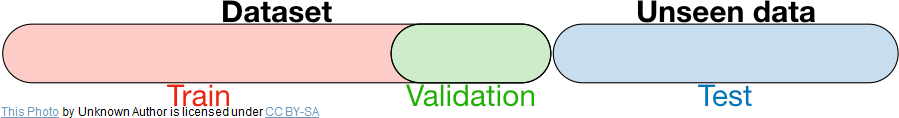

In [7]:
from IPython.core.display import Image
Image(filename='Img/Train-Test.png',width = 600, height = 800 )

You can use the Test data for validatation. 

## Split the data into training and test set

In [8]:
# train/test split
X_train, X_test, Y_train, Y_test = train_test_split(TC1data3, outcome,
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=123,
                                                    stratify = outcome)

## Let us define some parameters

* activation to be RELU
* batch_size is set to 20 
* number of classes is three (chosen a small number for performace) for this exercise. The code that is available from NIH FTP site will model 15 cancer site outputs.

In [9]:
# parameters
activation='relu'
batch_size=20
# Number of sites
classes=3

drop = 0.1
feature_subsample = 0
loss='categorical_crossentropy'

# metrics='accuracy'
out_act='softmax'

shuffle = False

### Note epochs should be greather than 10. For hands-on, I have chosen a smaller number

In [10]:
epochs=10

optimizer = optimizers.SGD(lr=0.1)
metrics = ['acc']

In [11]:
x_train_len = X_train.shape[1]

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [12]:
filters = 128
filter_len = 20
stride = 1

K.clear_session()


## Create and initialize the model

In [13]:
model = Sequential()

# model.add  1. CONV1D
model.add(Conv1D(filters = filters,
                 kernel_size = filter_len,
                 strides = stride,
                 padding='valid',
                 input_shape=(x_train_len, 1)))

## Create the topology of the architecture

In [14]:
# 2. Activation
model.add(Activation('relu'))

# 3. MaxPooling
model.add(MaxPooling1D(pool_size = 1))

filters = 128
filter_len = 10
stride = 1

# 4. Conv1D
model.add(Conv1D(filters=filters,
                 kernel_size=filter_len,
                 strides=stride,
                 padding='valid'))

# 5. Activation
model.add(Activation('relu'))

# 6. MaxPooling
model.add(MaxPooling1D(pool_size = 10))

# 7. Flatten
model.add(Flatten())

# 8. Dense
model.add(Dense(200))

# 9. activation
model.add(Activation('relu'))

# 10. dropout
model.add(Dropout(0.1))

#11. Dense
model.add(Dense(20))

#12. Activation
model.add(Activation('relu'))

#13. dropout
model.add(Dropout(0.1))

# 14. dense
model.add(Dense(3))

# 15. Activation
model.add(Activation(out_act))

## Compile and show the model summary

In [15]:
model.compile( loss= loss,
              optimizer = optimizer,
              metrics = metrics )

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 60464, 128)        2688      
_________________________________________________________________
activation_1 (Activation)    (None, 60464, 128)        0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 60464, 128)        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 60455, 128)        163968    
_________________________________________________________________
activation_2 (Activation)    (None, 60455, 128)        0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 6045, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 773760)           

In [16]:
# save
save = '.'
output_dir = "Output"

output_dir = save
if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model_name = 'tc1'
path = '{}/{}.autosave.model.h5'.format(output_dir, model_name)
checkpointer = ModelCheckpoint(filepath=path,
                               verbose=1,
                               save_weights_only=True,
                               save_best_only=True)

csv_logger = CSVLogger('{}/training.log'.format(output_dir))

In [17]:
# SR: change epsilon to min_delta
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=10,
                              verbose=1, mode='auto',
                              min_delta=0.0001,
                              cooldown=0,
                              min_lr=0)

In [18]:
# batch_size = 20
history = model.fit(X_train, Y_train, batch_size=batch_size,
                    epochs=epochs, verbose=1, validation_data=(X_test, Y_test),
                    callbacks = [checkpointer, csv_logger, reduce_lr])

Train on 112 samples, validate on 38 samples
Epoch 1/10
112/112 [==============================] - 444s 4s/step - loss: 4.2895 - acc: 0.3214 - val_loss: 1.0987 - val_acc: 0.3158

Epoch 00001: val_loss improved from inf to 1.09871, saving model to ./tc1.autosave.model.h5
Epoch 2/10
112/112 [==============================] - 458s 4s/step - loss: 1.1011 - acc: 0.2500 - val_loss: 1.0989 - val_acc: 0.3158

Epoch 00002: val_loss did not improve from 1.09871
Epoch 3/10
112/112 [==============================] - 536s 5s/step - loss: 1.1001 - acc: 0.2946 - val_loss: 1.0987 - val_acc: 0.3421

Epoch 00003: val_loss did not improve from 1.09871
Epoch 4/10
112/112 [==============================] - 464s 4s/step - loss: 1.0992 - acc: 0.3304 - val_loss: 1.0988 - val_acc: 0.3158

Epoch 00004: val_loss did not improve from 1.09871
Epoch 5/10
112/112 [==============================] - 438s 4s/step - loss: 1.0999 - acc: 0.3393 - val_loss: 1.0983 - val_acc: 0.3158

Epoch 00005: val_loss improved from 1.09

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)

print('Test score:', score[0])
print('Test accuracy:', score[1])

# serialize weights to HDF5
model.save_weights("{}/{}.model.h5".format(output_dir, model_name))
print("Saved model to disk")

# load weights into new model
loaded_model_yaml.load_weights('{}/{}.model.h5'.format(output_dir, model_name))
print("Loaded yaml model from disk")

## Warning

The output loss and accuracy shown above do not reflect the real learning. For good accuracy, we need to use the whole dataset. Here are the few epochs from the original dataset

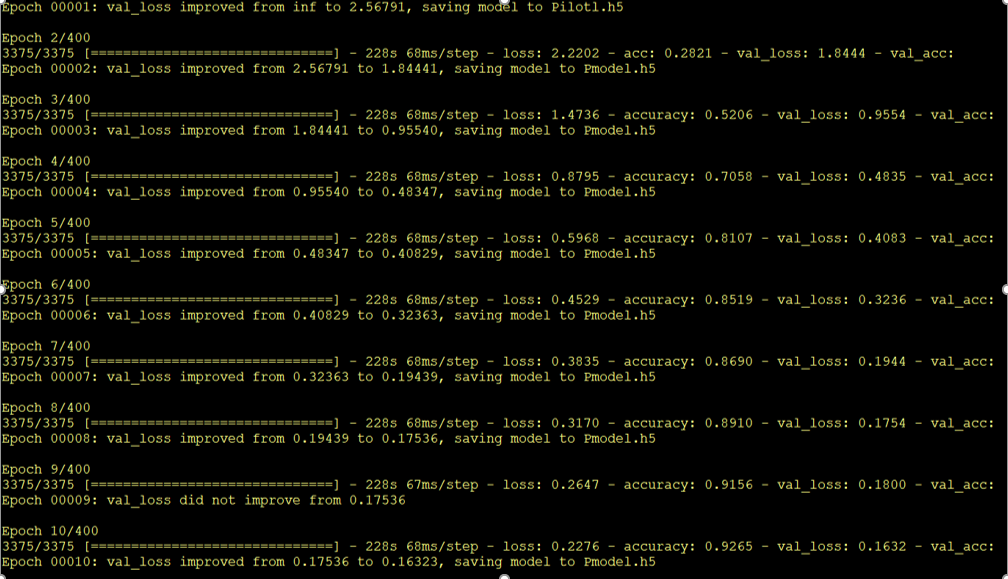

In [19]:
from IPython.core.display import Image
Image(filename='Img/TC1-Acc.PNG',width = 600, height = 800 )

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

tc1results = pd.read_csv("Output/tc1results.txt", index_col='epoch')

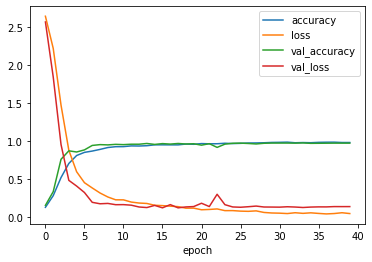

In [41]:
tc1results.plot()